In [1]:
%%capture
!pip install numpy pandas torch matplotlib

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


In [3]:
# Helper functions
EPS = 1e-8

def autocorr(X, Y):
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0
    r[r < -1] = 0

    return r


def get_autocorr(feature):
    feature = torch.from_numpy(feature)
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
        autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j],
                                                  feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()


def get_midpoints(a):
    return (np.max(a, axis=1).flatten() + np.min(a, axis=1).flatten()) / 2

def get_attribute_values(a):
    r = []
    for attribute_name, int_value in zip(WWT_ATTRIBUTE_NAMES, a):
        r.append(WWT_ATTRIBUTE_VALUES[attribute_name][int_value])
    return r


In [4]:
# Discrete variable mappings
WWT_ATTRIBUTE_NAMES = ["domain", "access type", "agent"]
WWT_ATTRIBUTE_VALUES = {
    "domain": [
        'commons.wikimedia.org', 
        'de.wikipedia.org', 
        'en.wikipedia.org', 
        'es.wikipedia.org', 
        'fr.wikipedia.org', 
        'ja.wikipedia.org', 
        'ru.wikipedia.org', 
        'www.mediawiki.org', 
        'zh.wikipedia.org'
    ],
    "access type": [
        "all-access", "desktop", "mobile-web",
    ],
    "agent": [
        "all-agents", "spider",
    ]
}


In [5]:
# Read data

S3_BASE_URL = "https://gretel-public-website.s3.us-west-2.amazonaws.com/datasets/wiki-web-traffic-data/"

# Training data
wwt = pd.read_csv(S3_BASE_URL + "wikipedia-web-traffic-training.csv", index_col=0)

experiments = [
    ("pytorch_fast", "wwt-synthetic-pytorch-fast.csv"),
    ("pytorch_original", "wwt-synthetic-pytorch-original.csv"),
    ("tf1", "wwt-synthetic-tf1.csv"),
]

synthetic = {}
for name, filename in experiments:
    df = pd.read_csv(S3_BASE_URL + filename, index_col=0)
    synthetic[name] = df
    

In [6]:
wwt_features = np.expand_dims(
    wwt.drop(columns=["domain", "access", "agent", "domain_name", "access_name", "agent_name"]).to_numpy(),
    axis=-1)

wwt_attributes = wwt[["domain", "access", "agent"]].to_numpy().astype("int")

synthetic_features = {
    name: np.expand_dims(df.drop(columns=["domain","access","agent"]).to_numpy(), axis=-1)
    for name, df in synthetic.items()
}

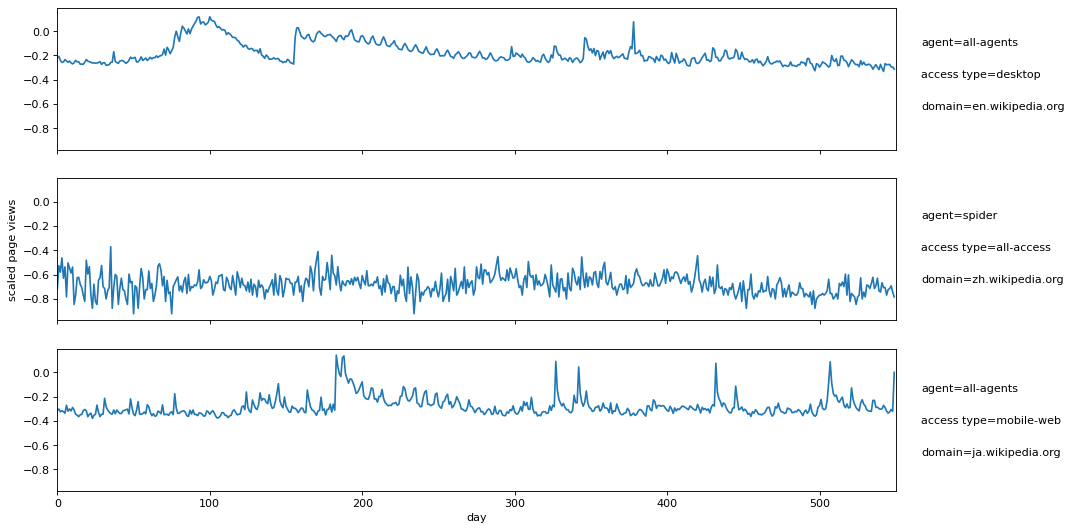

In [7]:
# Image 1, daily page views

# sample_indices = np.random.choice(len(wwt_features),3)
sample_indices = [8984, 5577, 3646]

fig = plt.figure(figsize=(16,8), dpi=80)

axes = fig.subplots(len(sample_indices), 1, sharey=True, sharex=True)

plot_index = 0
for ax, index in zip(axes, sample_indices):

    ax.plot(wwt_features[index,:,0])
    
    values = get_attribute_values(wwt_attributes[index, :])
    for i in range(len(values)):
        value = values[i]
        key = WWT_ATTRIBUTE_NAMES[i]
        fig.text(0.8, 0.18 + (2 - plot_index) * 0.27 + i * 0.05 , f"{key}={value}")
        
    plot_index += 1
    

axes[1].set_ylabel("scaled page views")
axes[2].set_xlabel("day")
axes[0].set_xlim(0, 550)
fig.subplots_adjust(right=0.78)

fig.savefig("page_views.png")
plt.show(fig)

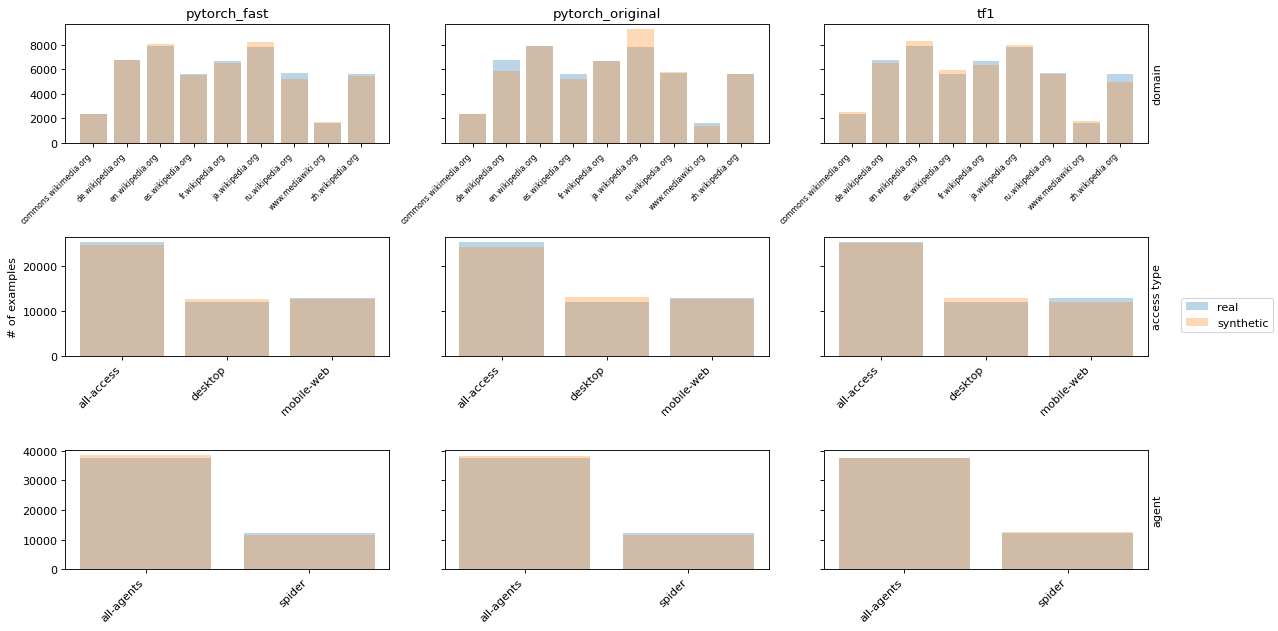

In [8]:
# Image 2, attribute distributions
# Based on Figure 19 of original paper

fig = plt.figure(figsize=(16,8), dpi=80)

axes = fig.subplots(len(WWT_ATTRIBUTE_NAMES), len(synthetic_features), sharey="row")

for index, (row_axes, attribute_name) in enumerate(zip(axes, WWT_ATTRIBUTE_NAMES)):    
    x = WWT_ATTRIBUTE_VALUES[attribute_name]
    
    real_counts = np.bincount(wwt_attributes[:,index])
    
    for ax, (name, df) in zip(row_axes, synthetic.items()):
        attributes = df[["domain", "access", "agent"]].to_numpy().astype("int")

        counts = np.bincount(attributes[:,index])
        
    
        ax.bar(x, real_counts, alpha=0.3, label="real")
        ax.bar(x, counts, alpha=0.3, label="synthetic")
        
        if index == 0:
            ax.set_title(name)
        ax.set_xticks(ax.get_xticks())
        if attribute_name == "domain":
            ax.set_xticklabels(x, rotation=45, fontsize=7, ha="right")
        else:
            ax.set_xticklabels(x, rotation=45, ha="right")
        
    row_axes[-1].yaxis.set_label_position("right")
    row_axes[-1].set_ylabel(attribute_name)
        
axes[1][0].set_ylabel("# of examples")

fig.tight_layout()
fig.subplots_adjust(right=0.9)
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(loc="center right", handles=handles, labels=labels)

fig.savefig("attributes.png")
plt.show(fig)
    
    

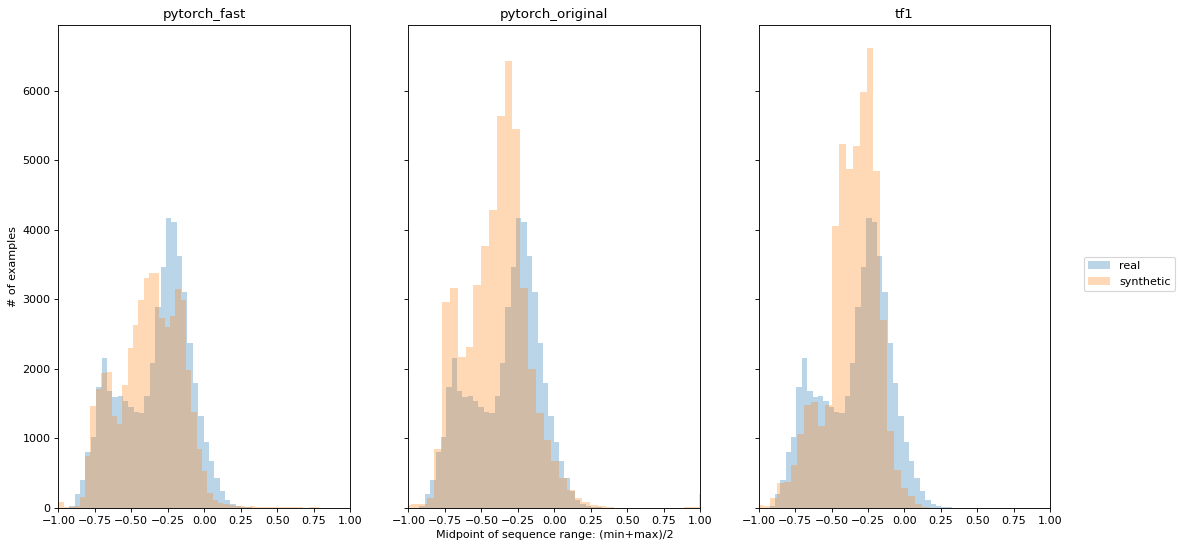

In [9]:
# Image 3, histogram of midpoints
# Recreation of Figure 6 from original paper

fig = plt.figure(figsize=(16,8), dpi=80)

axes = fig.subplots(1, len(synthetic_features), sharey=True, sharex=True)

wwt_midpoints = get_midpoints(wwt_features)


for ax, (name, f) in zip(axes, synthetic_features.items()):
    m = get_midpoints(f)
    
    ax.hist(wwt_midpoints , bins=50, alpha=0.3, label="real")
    ax.hist(m, bins=50, alpha=0.3, label="synthetic")
    
    ax.set_title(name)


axes[1].set_xlabel("Midpoint of sequence range: (min+max)/2")
axes[0].set_xlim(-1, 1)
axes[0].set_ylabel("# of examples")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(loc="center right", handles=handles, labels=labels)
fig.savefig("midpoints.png")
plt.show(fig)

In [10]:
# Compute autocorrelations
wwt_acf = get_autocorr(wwt_features)
synthetic_acfs = {}
for name, df in synthetic.items():
    features = np.expand_dims(df.drop(columns=["domain","access","agent"]).to_numpy(), axis=-1)
    
    acf = get_autocorr(features)
    synthetic_acfs[name] = acf


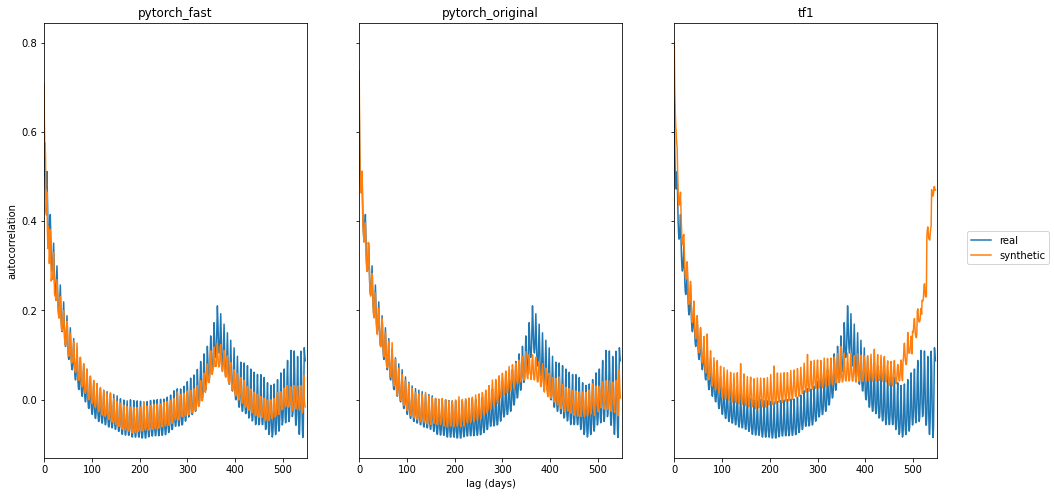

In [11]:
# Image 4, autocorrelation
# Recreation of Figure 1 from original paper

fig = plt.figure(figsize=(16,8))

axes = fig.subplots(1, len(synthetic_features), sharey=True, sharex=True)


for ax, (name, acf) in zip(axes, synthetic_acfs.items()):
    ax.plot(wwt_acf, label="real")
    ax.plot(acf, label="synthetic")
    
    ax.set_title(name)
    

axes[0].set_ylabel("autocorrelation")
axes[1].set_xlabel("lag (days)")
axes[0].set_xlim(0, 550)
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(loc="center right", handles=handles, labels=labels)

fig.savefig("autocorrelation.png")
plt.show()
